
# Fitting single crystal parameters with DAMASK simulations
This notebook processes the results from the demo workflow `fit_single_crystal_parameters`, and generates a plot of stress strain both simulated and experimental, showing the model converging on the desired deformation behavior with each pertubation of the plastic single crystal parameters.


In [1]:

import matflow as mf
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path


## Utility functions

In [ ]:
def clean_nonetypes(stress_array, strain_array):
    """
    For some reason experimental data has nonetypes:
    This function cleans the stress array of nonetypes
    and also ensures the strain array is matched to it.
    """
    # DEBUG
    # print(f"input array : {stress_array}")
    # print(f"bool array of nonetypes : {stress_array != np.array(None)}")
    
    cleaned_stress_array = stress_array[stress_array != np.array(None)]
    cleaned_strain_array = strain_array[stress_array != np.array(None)]

    return cleaned_stress_array, cleaned_strain_array




## Define workflow

In [2]:

workflow_path = Path("fit_single_crystal_parameters_2025-05-28_143539")
workflow = mf.Workflow(workflow_path)


Your workflow output (from `matflow show -f`) should look like this:
```
┌────┬───────────────────────────────────────────────┬──────────┬────────────────────────────┬────────────────────────────────────────────────┐
│ ID │ Name                                          │ Status   │ Times                      │ Actions                                        │
├────┼───────────────────────────────────────────────┼──────────┼────────────────────────────┼────────────────────────────────────────────────┤
│ 33 │ fit_single_crystal_parameters_2025-05-28_143… │ inactive │  sb.  2025-05-28 14:35:41  │  generate_microstructu…   0 | ■                │
│    │                                               │          │  st.             16:36:35  │  generate_volume_eleme…   0 | ■                │
│    │                                               │          │  en.             16:36:31  │  read_tensile_test_fro…   0 | ■                │
│    │                                               │          │                            │  simulate_VE_loading_d…   0 | ■■■■■■■■■■■■■■   │
│    │                                               │          │                            │                           1 | ■■■■■■■■■■■■■■   │
│    │                                               │          │                            │                           2 | ■■■■■■■■■■■■■■   │
│    │                                               │          │                            │                           3 | ■■■■■■■■■■■■■■   │
│    │                                               │          │                            │  fit_single_crystal_pa…   0 | ■■              
└────┴───────────────────────────────────────────────┴──────────┴────────────────────────────┴────────────────────────────────────────────────┘
```

## Extract and clean data

In [3]:
# show attrs of workflow obj with dir:
dir(workflow)

['_IndexPath1',
 '_IndexPath2',
 '_IndexPath3',
 '_Workflow__EAR_obj_map',
 '_Workflow__template_components',
 '_Workflow__wait_for_direct_jobscripts',
 '_Workflow__wait_for_scheduled_jobscripts',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abort_run',
 '_accept_pending',
 '_add_empty_loop',
 '_add_empty_task',
 '_add_file',
 '_add_loop',
 '_add_parameter_data',
 '_add_submission',
 '_add_task',
 '_add_unset_parameter_data',
 '_app',
 '_app_attr',
 '_check_loop_termination',
 '_creation_info',
 '_default_ts_fmt',
 '_default_ts_name_fmt',
 '_delete_no_confirm',
 '_exec_dir_name',
 '_get_empty_pending',
 '_get_new_task_unique_name'

In [9]:

## Experimental Stress-strains ##
exp_data = workflow.tasks.read_tensile_test_from_CSV.elements[0].iterations[0].outputs.tensile_test.value
exp_stress = np.array(exp_data['true_stress'])
exp_strain = np.array(exp_data['true_strain'])
# clean experimental data of nonetypes
exp_stress, exp_strain = clean_nonetypes(exp_stress, exp_strain)

## Simulated stress-strains ##
# Getting an error? try running twice.
VE_response = workflow.tasks.simulate_VE_loading_damask.elements[0].iterations[0].outputs.VE_response.value
sim_stress = np.array(VE_response['volume_data']['vol_avg_stress']['data'])
sim_strain = np.array(VE_response['volume_data']['vol_avg_strain']['data'])


input array : [None None -34700.0 ... None None None]
bool array of nonetypes : [False False  True ... False False False]
(171, 3, 3)
(171, 3, 3)


## Plot simulated stress strains against experimental

It is shown that with successive pertubations of the single crystal parameters `h_0_sl-sl`, `xi_0_sl`, and `xi_inf_sl`, the predicted stress-strain curve approaches the measured stress-strain curve. With the simulation more and more closely capturing the deformation behavior of the real material:

Sim 0 iter 0... 
Sim 0 iter 1... 
Sim 1 iter 0... 
Sim 1 iter 1... 
Sim 2 iter 0... 
Sim 2 iter 1... 
Sim 3 iter 0... 
Sim 3 iter 1... 


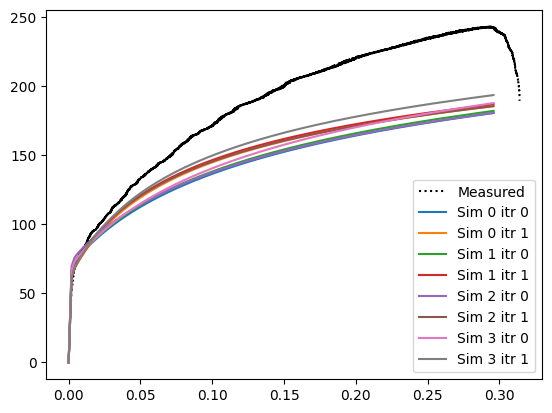

In [15]:

plt.figure(1)
plt.plot(exp_strain, exp_stress/1e6,
         color='k',
         linestyle="dotted",
         label="Measured")

for e, sim in enumerate(workflow.tasks.simulate_VE_loading_damask.elements):
    for i, itr in enumerate(sim.iterations):
        print(f"Sim {e} iter {i}... ")

        VE_response = itr.outputs.VE_response.value
        sim_stress = np.array(VE_response['volume_data']['vol_avg_stress']['data'])
        sim_strain = np.array(VE_response['volume_data']['vol_avg_strain']['data'])


        plt.plot(sim_strain[:,0,0], sim_stress[:,0,0]/1e6,
                 linestyle="solid",
                 label=f"Sim {e} itr {i}")

plt.legend()


## Plot regression value